In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scripts import MONGO_URL
from scripts.analysis import data, plot

plot.init_matplotlib()
W, H = 5.5, 2.5


def pad_missing_months(ts: pd.Series) -> pd.Series:
    start, end = ts.index[0], ts.index[-1]
    all_months = map(
        lambda month: month.strftime("%Y-%m"),
        pd.date_range(start=start, end=end, freq="MS"),
    )
    return ts.reindex(all_months, fill_value=0)


def aggreagte_user_ts(fake_type: str, repo_months: set[tuple[str, str]]) -> pd.Series:
    assert fake_type in ["low_activity", "clustered"]
    client = pymongo.MongoClient(MONGO_URL)
    ts_users = (
        pd.DataFrame(
            map(
                lambda x: {
                    "repo": x["repo"],
                    "month": x["starred_at"][:7],
                    "actor": x["actor"],
                },
                filter(
                    lambda x: (x["repo"], x["starred_at"][:7]) in repo_months,
                    list(
                        client.fake_stars[f"{fake_type}_stars"].find(
                            {
                                "repo": {"$in": [x[0] for x in repo_months]},
                                fake_type: True,
                            }
                        )
                    ),
                ),
            ),
        )
        .groupby("month")
        .agg({"actor": set})
    )
    ts_users.rename(columns={"actor": f"{fake_type}_actors"}, inplace=True)
    client.close()
    return pad_missing_months(ts_users)

In [2]:
repo_with_campaign = data.get_repos_with_campaign()
stars_by_month = data.get_fake_stars_by_month()
stars_by_month = stars_by_month[stars_by_month.month != "2025-01"]

In [3]:
ts_real = pd.read_csv("data/all_github_stars_by_month.csv").set_index("month")[
    "n_stars"
]
ts_fake = stars_by_month.groupby("month").sum()[
    ["n_stars_low_activity", "n_stars_clustered"]
]
ts_repos = pad_missing_months(
    stars_by_month[stars_by_month.anomaly].groupby("month").count()[["repo"]]
)

In [4]:
ts_users = (
    pd.read_csv("data/all_github_users_by_month.csv")
    .set_index("month")["n_active_users"]
    .sort_index()
)
repo_months = set(
    stars_by_month[stars_by_month.anomaly][["repo", "month"]].apply(tuple, axis=1)
)
ts_users_low_activity = aggreagte_user_ts("low_activity", repo_months)
ts_users_clustered = aggreagte_user_ts("clustered", repo_months)

ts_fake_users = pd.concat([ts_users_low_activity, ts_users_clustered], axis=1)
ts_fake_users.low_activity_actors = ts_fake_users.low_activity_actors.apply(
    lambda x: x if not pd.isna(x) and not x == 0 else set()
)
ts_fake_users.clustered_actors = ts_fake_users.clustered_actors.apply(
    lambda x: x if not pd.isna(x) and not x == 0 else set()
)
ts_fake_users["all"] = ts_fake_users.apply(
    lambda x: len(x["low_activity_actors"] | x["clustered_actors"]), axis=1
)
ts_fake_users["both"] = ts_fake_users.apply(
    lambda x: len(x["low_activity_actors"] & x["clustered_actors"]), axis=1
)
ts_fake_users["low_activity_actors"] = ts_fake_users["low_activity_actors"].apply(len)
ts_fake_users["clustered_actors"] = ts_fake_users["clustered_actors"].apply(len)
ts_fake_users["low_activity_only"] = (
    ts_fake_users["low_activity_actors"] - ts_fake_users["both"]
)
ts_fake_users["clustered_only"] = (
    ts_fake_users["clustered_actors"] - ts_fake_users["both"]
)

2024-07 0.1665952482978622 3499
2024-03 0.06593627001914446 117032


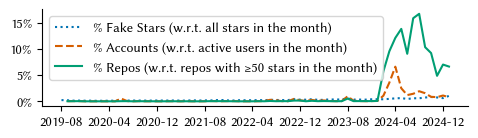

In [5]:
percentage = (ts_fake.n_stars_low_activity) / ts_real
all_spiky_repos = pd.read_csv("data/all_github_repos_with_spikes.csv")
all_spiky_repos = all_spiky_repos.groupby("month").count()

fig, ax = plt.subplots(1, 1, figsize=(W, H/2))
percentage.plot(kind="line", ax=ax, color="C0", linestyle=":")
(ts_fake_users["all"] / ts_users).plot(kind="line", ax=ax, color="C2", linestyle="--")
(ts_repos / all_spiky_repos).repo.plot(kind="line", ax=ax, color="C1", linestyle="-")
ax.legend(
    labels=[
        "% Fake Stars (w.r.t. all stars in the month)",
        "% Accounts (w.r.t. active users in the month)",
        "% Repos (w.r.t. repos with ≥50 stars in the month)",
    ]
)
ax.set_xticks(range(0, len(ts_repos), 8))
ax.set_xticklabels(ts_repos.index[::8])
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_yticklabels(["0%", "5%", "10%", "15%"])
ax.set_xlabel("")
plot.remove_spines(ax)
# fig.autofmt_xdate()
fig.savefig("plots/ts_percentage.pdf", bbox_inches="tight")

print(
    (ts_repos / all_spiky_repos).repo.idxmax(),
    (ts_repos / all_spiky_repos).repo.max(),
    ts_repos.repo.max(),
)
print(
    (ts_fake_users["all"] / ts_users).idxmax(),
    (ts_fake_users["all"] / ts_users).max(),
    ts_fake_users["all"].max(),
)